Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
FAKE NEWS DETECTOR - ML PROJECT (with BERT)

✓ All libraries imported successfully!

STEP 1: LOADING CSV DATA

Loading fake news data from: /content/drive/MyDrive/Colab Notebooks/data/Fake.csv
✓ Loaded 23481 fake news articles

Loading true news data from: /content/drive/MyDrive/Colab Notebooks/data/True.csv
✓ Loaded 21417 true news articles

Fake news columns: ['title', 'text', 'subject', 'date']
True news columns: ['title', 'text', 'subject', 'date']

Fake news sample:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  Decembe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔹 Tokenizing training data...
🔹 Tokenizing test data...

🔹 Training BERT model (optimized for speed)...
   Epoch 1/1, Loss: 0.3412

🔹 Evaluating BERT model...

   Accuracy:  0.9965
   Precision: 0.9927
   Recall:    1.0000
   F1-Score:  0.9963

FINAL RESULTS - MODEL COMPARISON

Accuracy Scores:
  BERT.......................... 0.9965
  Random Forest................. 0.9935
  Gradient Boosting............. 0.9915
  Support Vector Machine........ 0.9845
  Logistic Regression........... 0.9715
  Naive Bayes................... 0.9365

🏆 Best Model: BERT with 0.9965 accuracy

CREATING COMPREHENSIVE VISUALIZATIONS

✓ Comprehensive visualization saved as 'fake_news_detection_results.png'


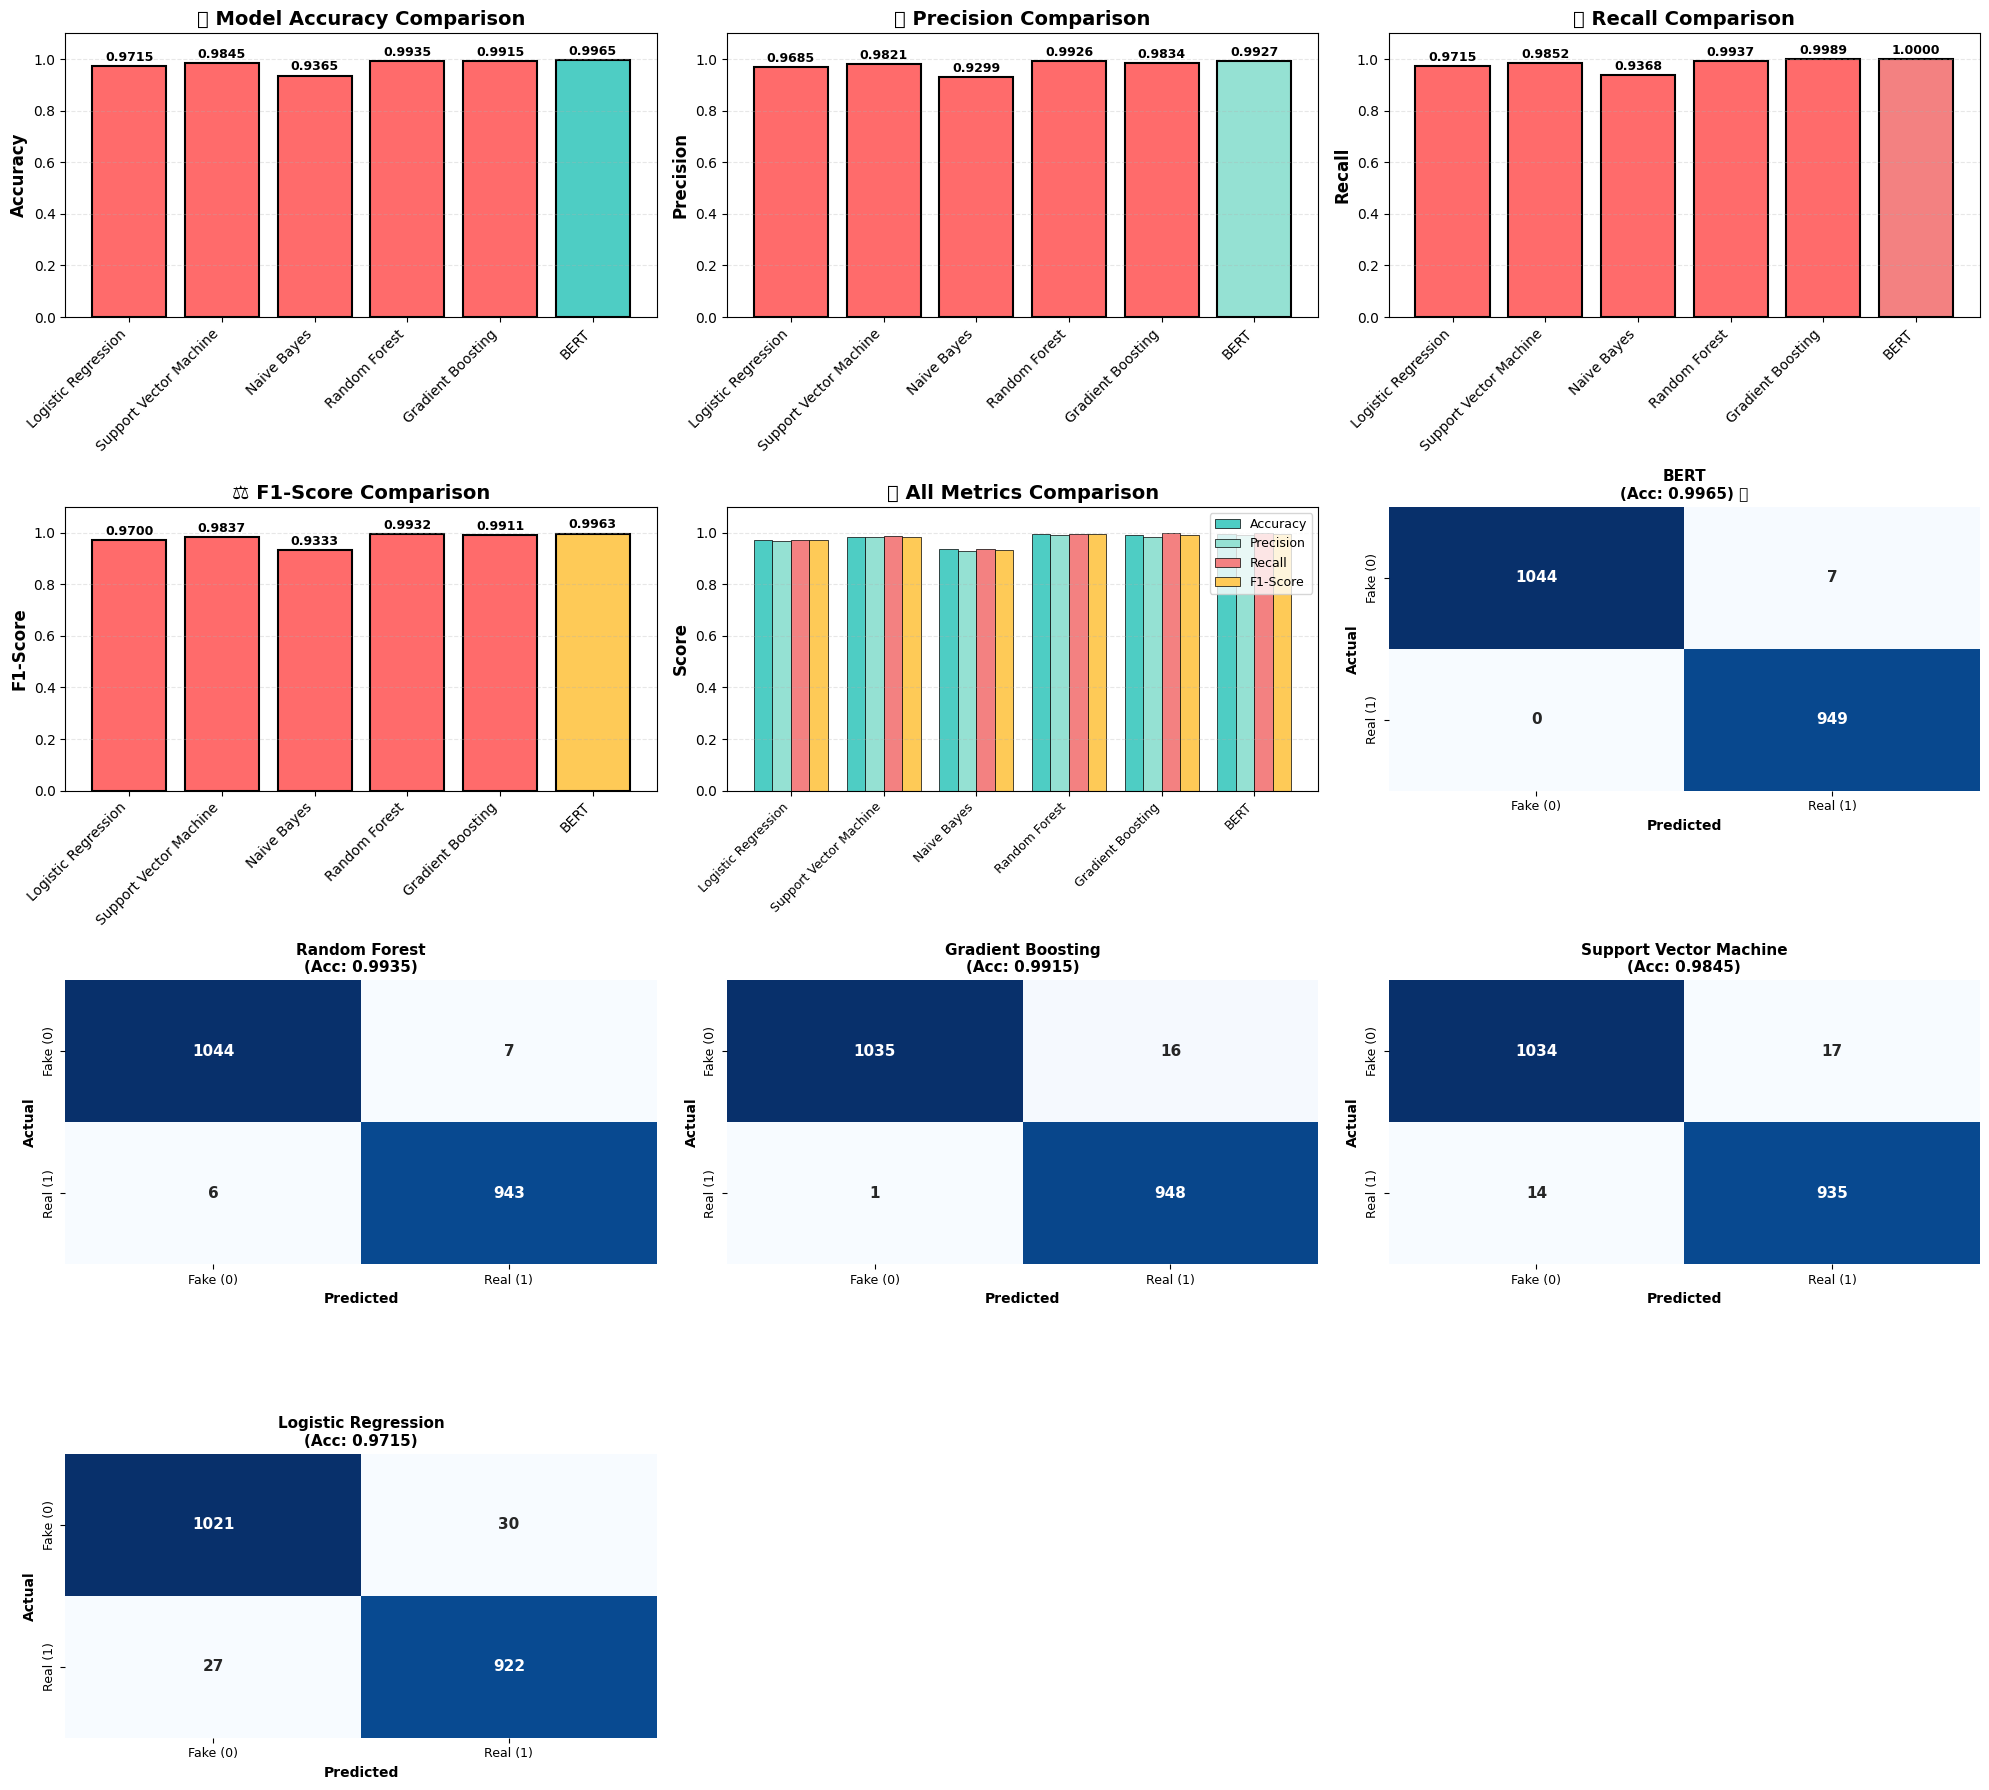


DETAILED METRICS TABLE

                 Model  Accuracy  Precision   Recall  F1-Score
                  BERT    0.9965   0.992678 1.000000  0.996325
         Random Forest    0.9935   0.992632 0.993678  0.993154
     Gradient Boosting    0.9915   0.983402 0.998946  0.991113
Support Vector Machine    0.9845   0.982143 0.985248  0.983693
   Logistic Regression    0.9715   0.968487 0.971549  0.970016
           Naive Bayes    0.9365   0.929916 0.936776  0.933333

DETAILED REPORT - BERT

              precision    recall  f1-score   support

   Fake News       1.00      0.99      1.00      1051
   Real News       0.99      1.00      1.00       949

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


✅ PROJECT COMPLETED SUCCESSFULLY!

📊 Results Summary:
   - Total articles processed: 9997
   - Training samples used: 2000
   - Test samples: 2000
   - Models trained: 6 (5 ML model

In [ ]:

# 1️⃣ IMPORTS
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            precision_recall_fscore_support, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# BERT imports
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

print("=" * 60)
print("FAKE NEWS DETECTOR - ML PROJECT (with BERT)")
print("=" * 60)
print("\n✓ All libraries imported successfully!")

# ==============================================
# 2️⃣ LOAD CSV FILES
# ==============================================
print("\n" + "=" * 60)
print("STEP 1: LOADING CSV DATA")
print("=" * 60)

FAKE_NEWS_FILE = '/content/drive/MyDrive/Colab Notebooks/data/Fake.csv'
TRUE_NEWS_FILE = '/content/drive/MyDrive/Colab Notebooks/data/True.csv'

try:
    print(f"\nLoading fake news data from: {FAKE_NEWS_FILE}")
    df_fake = pd.read_csv(FAKE_NEWS_FILE)
    print(f"✓ Loaded {len(df_fake)} fake news articles")

    print(f"\nLoading true news data from: {TRUE_NEWS_FILE}")
    df_true = pd.read_csv(TRUE_NEWS_FILE)
    print(f"✓ Loaded {len(df_true)} true news articles")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Could not find CSV file!")
    print(f"   {e}")
    print("\n💡 Please update the file paths in the script:")
    print("   - FAKE_NEWS_FILE = 'your_fake_news_file.csv'")
    print("   - TRUE_NEWS_FILE = 'your_true_news_file.csv'")
    exit(1)

# Display file information
print(f"\nFake news columns: {list(df_fake.columns)}")
print(f"True news columns: {list(df_true.columns)}")

print(f"\nFake news sample:")
print(df_fake.head(2))

print(f"\nTrue news sample:")
print(df_true.head(2))

# Add labels
df_fake['label'] = 0  # 0 = Fake News
df_true['label'] = 1  # 1 = Real News

# Combine datasets - use smaller sample for faster training
sample_size = min(10000, len(df_fake) + len(df_true))
df_combined = pd.concat([df_fake, df_true]).sample(n=sample_size, frac=None, random_state=42).reset_index(drop=True)
df = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✓ Combined dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())

# ==============================================
# 3️⃣ TEXT PREPROCESSING
# ==============================================
print("\n" + "=" * 60)
print("STEP 2: TEXT PREPROCESSING")
print("=" * 60)

def clean_text(text):
    """Clean and normalize text data"""
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Remove special chars
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    return text.lower().strip()

# Combine title and text (adjust column names if different in your CSV)
# Common column names: 'title', 'text', 'subject', 'content', 'article'
if 'title' in df.columns and 'text' in df.columns:
    df['combined_text'] = df['title'].fillna('') + " " + df['text'].fillna('')
elif 'title' in df.columns:
    df['combined_text'] = df['title'].fillna('')
elif 'text' in df.columns:
    df['combined_text'] = df['text'].fillna('')
else:
    # Use the first text column found
    text_col = df.select_dtypes(include=['object']).columns[0]
    print(f"⚠️  Using column '{text_col}' as text source")
    df['combined_text'] = df[text_col].fillna('')

# Apply cleaning
df['combined_text'] = df['combined_text'].apply(clean_text)

# Remove empty texts
df = df[df['combined_text'].str.len() > 0].reset_index(drop=True)

print(f"\n✓ Text preprocessing completed!")
print(f"✓ Final dataset size: {len(df)} articles")
print(f"\nExample cleaned text:\n{df['combined_text'].iloc[0][:200]}...")

# ==============================================
# 4️⃣ TRAIN-TEST SPLIT
# ==============================================
print("\n" + "=" * 60)
print("STEP 3: TRAIN-TEST SPLIT")
print("=" * 60)

X = df['combined_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Use a smaller subset for faster training
subset_size = min(2000, len(X_train))
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

print(f"\n✓ Training samples: {len(X_train)} (using {len(X_train_subset)} for models)")
print(f"✓ Testing samples: {len(X_test)}")
print(f"\nTraining labels: Fake={sum(y_train==0)}, Real={sum(y_train==1)}")
print(f"Testing labels: Fake={sum(y_test==0)}, Real={sum(y_test==1)}")

# ==============================================
# 5️⃣ MACHINE LEARNING MODELS
# ==============================================
print("\n" + "=" * 60)
print("STEP 4: TRAINING ML MODELS")
print("=" * 60)

# TF-IDF Vectorization (for traditional ML models)
print("\nCreating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=2)
X_train_vec = tfidf.fit_transform(X_train_subset)
X_test_vec = tfidf.transform(X_test)
print(f"✓ Feature matrix shape: {X_train_vec.shape}")

# Define traditional ML models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": LinearSVC(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
detailed_results = {}

print("\n" + "-" * 60)
print("Training Traditional ML Models...")
print("-" * 60)

for name, model in models.items():
    print(f"\n🔹 Training {name}...")

    # Train
    model.fit(X_train_vec, y_train_subset)

    # Predict
    preds = model.predict(X_test_vec)

    # Metrics
    acc = accuracy_score(y_test, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    cm = confusion_matrix(y_test, preds)

    results[name] = acc
    detailed_results[name] = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'model': model
    }

    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

# ==============================================
# 6️⃣ BERT MODEL TRAINING
# ==============================================
print("\n" + "=" * 60)
print("STEP 5: TRAINING BERT MODEL")
print("=" * 60)

print("\n🔹 Loading BERT tokenizer and model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"   Using device: {device}")

# Load pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
bert_model.to(device)

# Use even smaller subset for BERT (1000 samples for speed)
bert_train_size = min(1000, len(X_train_subset))
X_bert_train = X_train_subset[:bert_train_size]
y_bert_train = y_train_subset[:bert_train_size]

# Tokenize texts
print("\n🔹 Tokenizing training data...")
train_encodings = tokenizer(list(X_bert_train), truncation=True, padding=True, max_length=128)
print("🔹 Tokenizing test data...")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Create PyTorch datasets
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_bert_train)
test_dataset = NewsDataset(test_encodings, y_test)

# Create dataloaders with larger batch size for speed
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Training function
def train_bert(model, train_loader, device, epochs=1, lr=2e-5):
    optimizer = AdamW(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"   Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

# Evaluation function
def evaluate_bert(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)

# Train BERT
print("\n🔹 Training BERT model (optimized for speed)...")
bert_model = train_bert(bert_model, train_loader, device, epochs=1, lr=2e-5)

# Evaluate BERT
print("\n🔹 Evaluating BERT model...")
bert_preds, bert_labels = evaluate_bert(bert_model, test_loader, device)

bert_acc = accuracy_score(bert_labels, bert_preds)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(bert_labels, bert_preds, average='binary')
bert_cm = confusion_matrix(bert_labels, bert_preds)

results["BERT"] = bert_acc
detailed_results["BERT"] = {
    'accuracy': bert_acc,
    'precision': bert_precision,
    'recall': bert_recall,
    'f1': bert_f1,
    'confusion_matrix': bert_cm,
    'model': bert_model
}

print(f"\n   Accuracy:  {bert_acc:.4f}")
print(f"   Precision: {bert_precision:.4f}")
print(f"   Recall:    {bert_recall:.4f}")
print(f"   F1-Score:  {bert_f1:.4f}")

# ==============================================
# 7️⃣ RESULTS COMPARISON
# ==============================================
print("\n" + "=" * 60)
print("FINAL RESULTS - MODEL COMPARISON")
print("=" * 60)

print("\nAccuracy Scores:")
for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model_name:.<30} {accuracy:.4f}")

# Find best model
best_model_name = max(results, key=results.get)
print(f"\n🏆 Best Model: {best_model_name} with {results[best_model_name]:.4f} accuracy")

# ==============================================
# 8️⃣ COMPREHENSIVE VISUALIZATIONS
# ==============================================
print("\n" + "=" * 60)
print("CREATING COMPREHENSIVE VISUALIZATIONS")
print("=" * 60)

# Create figure with subplots
fig = plt.figure(figsize=(20, 18)) # Increased height for 4 rows

# 1. Accuracy Comparison
ax1 = plt.subplot(4, 3, 1)
colors = ['#FF6B6B' if name != best_model_name else '#4ECDC4' for name in results.keys()]
bars = ax1.bar(range(len(results)), list(results.values()), color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(results)))
ax1.set_xticklabels(results.keys(), rotation=45, ha='right', fontsize=10)
ax1.set_ylim(0, 1.1)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('📊 Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for i, (name, value) in enumerate(results.items()):
    ax1.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=9, fontweight='bold')

# 2. Precision Comparison
ax2 = plt.subplot(4, 3, 2)
precisions = [detailed_results[name]['precision'] for name in results.keys()]
colors = ['#FF6B6B' if detailed_results[name]['precision'] != max(precisions) else '#95E1D3' for name in results.keys()]
ax2.bar(range(len(results)), precisions, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(results)))
ax2.set_xticklabels(results.keys(), rotation=45, ha='right', fontsize=10)
ax2.set_ylim(0, 1.1)
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title('🎯 Precision Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for i, val in enumerate(precisions):
    ax2.text(i, val + 0.02, f'{val:.4f}', ha='center', fontsize=9, fontweight='bold')

# 3. Recall Comparison
ax3 = plt.subplot(4, 3, 3)
recalls = [detailed_results[name]['recall'] for name in results.keys()]
colors = ['#FF6B6B' if detailed_results[name]['recall'] != max(recalls) else '#F38181' for name in results.keys()]
ax3.bar(range(len(results)), recalls, color=colors, edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(len(results)))
ax3.set_xticklabels(results.keys(), rotation=45, ha='right', fontsize=10)
ax3.set_ylim(0, 1.1)
ax3.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax3.set_title('🔍 Recall Comparison', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
for i, val in enumerate(recalls):
    ax3.text(i, val + 0.02, f'{val:.4f}', ha='center', fontsize=9, fontweight='bold')

# 4. F1-Score Comparison
ax4 = plt.subplot(4, 3, 4)
f1_scores = [detailed_results[name]['f1'] for name in results.keys()]
colors = ['#FF6B6B' if detailed_results[name]['f1'] != max(f1_scores) else '#FECA57' for name in results.keys()]
ax4.bar(range(len(results)), f1_scores, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(len(results)))
ax4.set_xticklabels(results.keys(), rotation=45, ha='right', fontsize=10)
ax4.set_ylim(0, 1.1)
ax4.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax4.set_title('⚖️ F1-Score Comparison', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
for i, val in enumerate(f1_scores):
    ax4.text(i, val + 0.02, f'{val:.4f}', ha='center', fontsize=9, fontweight='bold')

# 5. All Metrics Comparison (Radar-like bar chart)
ax5 = plt.subplot(4, 3, 5)
x_pos = np.arange(len(results))
width = 0.2
ax5.bar(x_pos - 1.5*width, [detailed_results[name]['accuracy'] for name in results.keys()],
        width, label='Accuracy', color='#4ECDC4', edgecolor='black', linewidth=0.5)
ax5.bar(x_pos - 0.5*width, [detailed_results[name]['precision'] for name in results.keys()],
        width, label='Precision', color='#95E1D3', edgecolor='black', linewidth=0.5)
ax5.bar(x_pos + 0.5*width, [detailed_results[name]['recall'] for name in results.keys()],
        width, label='Recall', color='#F38181', edgecolor='black', linewidth=0.5)
ax5.bar(x_pos + 1.5*width, [detailed_results[name]['f1'] for name in results.keys()],
        width, label='F1-Score', color='#FECA57', edgecolor='black', linewidth=0.5)
ax5.set_ylabel('Score', fontsize=12, fontweight='bold')
ax5.set_title('📈 All Metrics Comparison', fontsize=14, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(results.keys(), rotation=45, ha='right', fontsize=9)
ax5.legend(fontsize=9, loc='upper right')
ax5.set_ylim(0, 1.1)
ax5.grid(axis='y', alpha=0.3, linestyle='--')

# 6-10. Confusion Matrices for top 5 models
top_models = sorted(results.items(), key=lambda x: x[1], reverse=True)[:5]
for idx, (model_name, _) in enumerate(top_models, start=6):
    ax = plt.subplot(4, 3, idx)
    cm = detailed_results[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                cbar_kws={'label': 'Count'}, annot_kws={'size': 11, 'weight': 'bold'})
    accuracy = detailed_results[model_name]['accuracy']
    title = f'{model_name}\n(Acc: {accuracy:.4f})'
    if model_name == best_model_name:
        title += ' 🏆'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=10, fontweight='bold')
    ax.set_xticklabels(['Fake (0)', 'Real (1)'], fontsize=9)
    ax.set_yticklabels(['Fake (0)', 'Real (1)'], fontsize=9)

plt.tight_layout()
plt.savefig('fake_news_detection_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Comprehensive visualization saved as 'fake_news_detection_results.png'")
plt.show()

# Create a detailed comparison table
print("\n" + "=" * 60)
print("DETAILED METRICS TABLE")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [detailed_results[name]['accuracy'] for name in results.keys()],
    'Precision': [detailed_results[name]['precision'] for name in results.keys()],
    'Recall': [detailed_results[name]['recall'] for name in results.keys()],
    'F1-Score': [detailed_results[name]['f1'] for name in results.keys()]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\n" + comparison_df.to_string(index=False))

# Detailed report for best model
print("\n" + "=" * 60)
print(f"DETAILED REPORT - {best_model_name.upper()}")
print("=" * 60)

if best_model_name == "BERT":
    preds = bert_preds
    labels = bert_labels
else:
    preds = detailed_results[best_model_name]['model'].predict(X_test_vec)
    labels = y_test

print("\n" + classification_report(labels, preds, target_names=['Fake News', 'Real News']))

print("\n" + "=" * 60)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"\n📊 Results Summary:")
print(f"   - Total articles processed: {len(df)}")
print(f"   - Training samples used: {len(X_train_subset)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Models trained: {len(models) + 1} (5 ML models + BERT)")
print(f"   - Best accuracy: {results[best_model_name]:.4f}")
print(f"   - Best model: {best_model_name}")
print(f"\n   BERT Model Results: Accuracy={bert_acc:.4f}, Precision={bert_precision:.4f}, Recall={bert_recall:.4f}, F1={bert_f1:.4f}")
